<a href="https://colab.research.google.com/github/yassinekoubaa/MMAI894/blob/main/Deep_clean_calinski_harabasz_Silhouette_50k_Clusters_GloVe_enron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

#import tensorflow as tf
import tensorflow.compat.v1 as tf
import collections
import os
import random
import numpy as np
from tqdm import tqdm
from six.moves import urllib
from six.moves import xrange 
import sys, email
import pandas as pd 
import math


In [ ]:
#########################################################
# Load Enron dataset
#########################################################

ENRON_EMAIL_DATASET_PATH = '/content/drive/MyDrive/894/Group Project/enron.csv'

# load enron dataset
import pandas as pd 
df = pd.read_csv(ENRON_EMAIL_DATASET_PATH)

In [ ]:
emails_df = df.copy()

print(emails_df.info())
emails_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Message-ID  517401 non-null  object
 1   Date        517401 non-null  object
 2   From        517401 non-null  object
 3   To          495554 non-null  object
 4   Subject     498215 non-null  object
 5   Message     517401 non-null  object
 6   Cc          127881 non-null  object
 7   Bcc         127881 non-null  object
dtypes: object(8)
memory usage: 31.6+ MB
None


,Message-ID,Date,From,To,Subject,Message,Cc,Bcc
0,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,NaN,Here is our forecast\n\n \n,NaN,NaN
1,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,NaN,NaN
2,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!\n,NaN,NaN
3,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,"Randy,\n\n Can you send me a schedule of the s...",NaN,NaN
4,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45. \n,NaN,NaN


In [ ]:
#########################################################
# Sort out required email features: date, subject, content
#########################################################

## Helper functions
message = emails_df

emails_df['Content'] = emails_df['Message']

# keep only Subject and Content
emails_df = emails_df[['Date','Subject','Content']]


In [ ]:
emails_df.head()

,Date,Subject,Content
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",NaN,Here is our forecast\n\n \n
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",Re:,Traveling to have a business meeting takes the...
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",Re: test,test successful. way to go!!!\n
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",NaN,"Randy,\n\n Can you send me a schedule of the s..."
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",Re: Hello,Let's shoot for Tuesday at 11:45. \n


In [ ]:
#########################################################
# Deep Cleaning
#########################################################
from sklearn.impute import SimpleImputer 
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#########################################################
# Clean Subject and Content
#########################################################
 
# Copy our Enron data set
emails_sample_df = emails_df.copy()

import string, re
# clean up subject line
# Start by removing NaN
imputer_cat = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer_cat.fit(emails_sample_df[['Subject']])
emails_sample_df['Subject'] = imputer_cat.transform(emails_sample_df[['Subject']])
# General Cleaning 
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.lower()
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r're:', ' ', regex=True) 
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'fw:', ' ', regex=True) 
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'[^a-z]', ' ', regex=True)  
emails_sample_df['Subject'] = emails_sample_df['Subject'].str.replace(r'\s+', ' ', regex=True)  
emails_sample_df['Subject'] = emails_sample_df['Subject'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# clean up content line
emails_sample_df['Content'] = emails_sample_df['Content'].str.lower()
emails_sample_df['Content'] = emails_sample_df['Content'].str.replace(r'[^a-z]', ' ', regex=True)  
emails_sample_df['Content'] = emails_sample_df['Content'].str.replace(r'\s+', ' ', regex=True)  
emails_sample_df['Content'] = emails_sample_df['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# create sentence list 
emails_text = (emails_sample_df["Subject"] + emails_sample_df["Content"]).tolist()

#sentences = ' '.join(emails_text)
sentences = ' '.join([str(item) for item in emails_text])
words_0 = sentences.split()

In [ ]:
words = words_0.copy()
print('Data size', len(words))

Data size 91301033


In [ ]:
# get unique words and map to glove set
print('Unique word count', len(set(words))) 

Unique word count 720370


In [ ]:
# drop rare words
vocabulary_size = 50000

In [ ]:
def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in tqdm(words):
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)

del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

100%|██████████| 91301033/91301033 [00:34<00:00, 2681205.16it/s]

Most common words (+UNK) [['UNK', 2940246], ('enron', 1879784), ('com', 1354135), ('ect', 1142407), ('hou', 579178)]
Sample data [558, 0, 3901, 42, 60, 1517, 1347, 1121, 1535, 1838] ['missing', 'UNK', 'traveling', 'business', 'meeting', 'takes', 'fun', 'trip', 'especially', 'prepare']


In [ ]:
####################################################################
# find matches with glove 
####################################################################
GLOVE_DATASET_PATH = '/content/drive/MyDrive/Pre-trained/glove.840B.300d.txt'

from tqdm import tqdm
import string
embeddings_index = {}
f = open(GLOVE_DATASET_PATH)
word_counter = 0
for line in tqdm(f):
  try:

      values = line.split()
      word = values[0]
      if word in dictionary:
          coefs = np.asarray(values[1:], dtype='float32',)
          embeddings_index[word] = coefs
      word_counter += 1
  
  except:
       values = line.split()
       word = ". . ."
       if word in dictionary:
          coefs = np.asarray(values[3:], dtype='float32',)
          embeddings_index[word] = coefs
       word_counter += 1


f.close()
print('Found %s word vectors matching enron data set.' % len(embeddings_index))
print('Total words in GloVe data set: %s' % word_counter)

2196017it [01:18, 27910.86it/s]

Found 38577 word vectors matching enron data set.
Total words in GloVe data set: 2196017


In [ ]:
# create a dataframe using the embedded vectors and attach the key word as row header
import pandas as pd
enrond_dataframe = pd.DataFrame(embeddings_index)
enrond_dataframe = pd.DataFrame.transpose(enrond_dataframe)

In [ ]:
enrond_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
one,0.054071,0.111100,-0.145570,-0.024294,0.38110,-0.143890,-0.179980,-0.310790,-0.007969,2.6538,...,-0.224790,-0.034352,-0.082647,-0.134850,-0.11371,-0.072454,-0.073029,-0.27098,0.044033,0.003769
like,-0.184170,0.055115,-0.369530,-0.208950,0.25672,0.301420,0.162990,-0.164370,-0.070268,2.1638,...,0.029923,0.194840,-0.133680,0.002850,-0.30414,0.285390,-0.331090,-0.23808,0.371320,0.361970
would,-0.049291,0.204830,-0.128080,-0.086686,-0.11584,-0.063130,-0.111880,-0.154930,-0.309140,3.1112,...,-0.236870,0.226060,0.117450,0.083891,0.15051,0.111670,-0.352840,-0.28529,0.337030,0.123350
time,0.172430,0.275020,0.050863,-0.196050,-0.23852,0.040335,-0.126400,-0.207010,0.087383,2.7350,...,-0.103290,0.024095,-0.217210,-0.082729,0.21785,-0.067727,-0.315060,0.12288,-0.285770,0.009371
get,-0.268790,0.174830,-0.356330,0.003189,0.15331,-0.032166,-0.019777,-0.040671,0.078706,2.4472,...,-0.094698,-0.013470,0.061898,-0.125740,0.14849,-0.202300,-0.174510,-0.17138,0.268460,0.198660


In [ ]:
# finding optimal number of clusters

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

100%|██████████| 3/3 [3:27:47<00:00, 4155.95s/it]


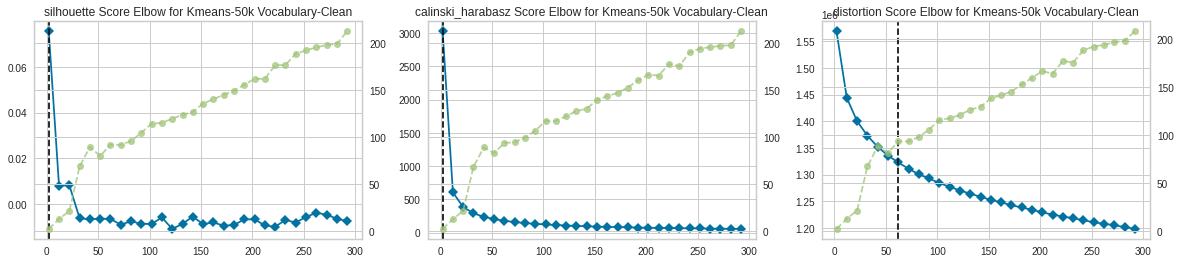

In [ ]:
## finding optimal number of clusters
# Plot Elbow Score for Metrics - silhouette 
cluster=np.arange(start=2, stop=300, step=10)
cltuple=tuple(cluster)

fig, ax = plt.subplots(1, 3, figsize=(20,4) )
i=0 # initiate axis

for vismetrics in tqdm([ "silhouette", "calinski_harabasz", "distortion"]):
    # Defining the Algorithm
    model = KMeans(random_state=42)
    #Create Elbow instance for different metrics
    visualizer = KElbowVisualizer( model,  k=cltuple, metric=vismetrics, timings=True, locate_elbow=True, ax=ax[i])
    ax[i].set(title=str(vismetrics)+' Score Elbow for Kmeans-50k Vocabulary-Clean')
    #Fit the visualizer
    visualizer.fit(enrond_dataframe)
    i += 1

In [ ]:

#########################################################
# Check out some clusters
#########################################################


 
# See what it learns and look at clusters to pull out major themes in the data
CLUSTER_SIZE = 50
# cluster vector and investigate top groups

kmeans = KMeans(n_clusters=CLUSTER_SIZE)
cluster_make = kmeans.fit_predict(enrond_dataframe)

labels = kmeans.predict(enrond_dataframe)
import collections
cluster_frequency = collections.Counter(labels)
print(cluster_frequency)
cluster_frequency.most_common()

clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(list(enrond_dataframe.index)[n])
    else:
        clusters[item] = [list(enrond_dataframe.index)[n]]
    n +=1

for k,v in cluster_frequency.most_common(100):
  print('\n\n')
  print('Cluster:', k)
  print (' '.join(clusters[k]))

Counter({14: 1739, 34: 1513, 19: 1466, 7: 1436, 45: 1335, 12: 1251, 33: 1228, 23: 1227, 29: 1106, 22: 991, 41: 979, 40: 911, 9: 903, 37: 873, 46: 842, 8: 830, 21: 824, 28: 818, 0: 815, 17: 803, 3: 801, 5: 781, 15: 769, 32: 736, 1: 729, 26: 683, 30: 677, 16: 661, 4: 646, 20: 629, 6: 623, 11: 619, 49: 613, 38: 602, 44: 588, 39: 561, 18: 541, 25: 538, 47: 508, 43: 488, 27: 475, 2: 459, 35: 457, 48: 423, 10: 416, 13: 394, 42: 370, 36: 342, 31: 306, 24: 252})



Cluster: 14
ruminations beaty groff conger lorenz ziegler dorman keeling dewar goulding zander keely rubens foy vitale lyne hendon suzette rapp hillier clementi verna munn horst spearman cotten haag denning prejean klee shute flavin cady condon smoot englander hagel hutcherson leif minter greif carin jacqui trudy philipp crump marbury rorschach gunnar kellan jami bloch bollinger schmitt staci stoll holtz coen janey marchand haller ballmer voss reiner heinrich henning bayless konrad vann posner sainsbury danforth morin jarrod maryann

In [ ]:
# Generate a word cloud image
from wordcloud import WordCloud


def display_wordcloud(top_words, n_components):
    plt.figure(figsize=(48, 64))
    j = np.ceil(n_components/4)
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 4, i ).set_title("Cluster #" + str(t))
        plt.plot()
        mywords = ' '.join(top_words[t])
        plt.axis("off")
        wordcloud = WordCloud(max_font_size=12).generate(mywords)
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.show();

n_components = 50
display_wordcloud(clusters, n_components)

In [ ]:
#########################################################
# Check out some clusters
#########################################################


 
# See what it learns and look at clusters to pull out major themes in the data
CLUSTER_SIZE = 64 
# cluster vector and investigate top groups

kmeans = KMeans(n_clusters=CLUSTER_SIZE)
cluster_make = kmeans.fit_predict(enrond_dataframe)

labels = kmeans.predict(enrond_dataframe)
import collections
cluster_frequency = collections.Counter(labels)
print(cluster_frequency)
cluster_frequency.most_common()

clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(list(enrond_dataframe.index)[n])
    else:
        clusters[item] = [list(enrond_dataframe.index)[n]]
    n +=1

for k,v in cluster_frequency.most_common(100):
  print('\n\n')
  print('Cluster:', k)
  print (' '.join(clusters[k]))

Counter({11: 1698, 7: 1393, 1: 1274, 19: 1242, 34: 1045, 47: 1003, 33: 982, 37: 944, 56: 941, 2: 901, 31: 894, 40: 861, 52: 839, 15: 810, 41: 792, 3: 786, 6: 749, 63: 713, 18: 699, 60: 690, 22: 656, 12: 622, 62: 602, 29: 602, 23: 601, 38: 584, 54: 583, 55: 551, 53: 543, 61: 543, 10: 542, 39: 539, 9: 517, 49: 510, 59: 510, 28: 491, 5: 477, 30: 474, 43: 456, 45: 452, 17: 452, 32: 441, 26: 435, 13: 434, 48: 430, 0: 429, 21: 425, 14: 423, 42: 392, 16: 388, 51: 381, 46: 374, 35: 374, 25: 372, 27: 360, 20: 356, 4: 351, 57: 348, 44: 279, 50: 244, 8: 229, 58: 203, 24: 200, 36: 146})



Cluster: 11
ruminations kirsch berk hiddleston sauer lorenz ziegler dorman keeling schilling thad scholes zander milt rubens griff witter foy lyne eason galen hendon rapp reade clementi verna horst hamish haag denning prejean klee shute cady bennie condon smoot gillan mendel weill hagel gord hutcherson minter trudy battaglia maas crump marbury gunnar starks bloch legg schmitt beek stoll holtz coen jacoby oren bu

In [ ]:
# Generate a word cloud image
from wordcloud import WordCloud


def display_wordcloud(top_words, n_components):
    plt.figure(figsize=(48, 64))
    j = np.ceil(n_components/5)
    for t in range(n_components):
        i=t+1
        plt.subplot(j, 5, i ).set_title("Cluster #" + str(t))
        plt.plot()
        mywords = ' '.join(top_words[t])
        plt.axis("off")
        wordcloud = WordCloud(max_font_size=12).generate(mywords)
        plt.imshow(wordcloud, interpolation="bilinear")
    plt.show();

n_components = 64
display_wordcloud(clusters, n_components)